<a href="https://colab.research.google.com/github/GabriStucchi/GranularSynth/blob/master/dcase_autoencoder_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import glob
import os
import math
import sys
import gc
import csv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Flatten, Dense, BatchNormalization, LeakyReLU, Add, Softmax, Layer, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from sklearn import metrics
import random

import librosa
from librosa import display

In [2]:
print(tf.__version__)
!nvidia-smi

2.8.0
Tue Apr 12 13:15:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/DCASE2020
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DCASE2020
2D_autoencoder_result/        classification_result/    logs/
baseline.yaml                 class_train_baseline.log  train_baseline.log
classification_baseline.yaml  dev_data/
classification_model/         id_assignment.yaml


# **Parameters**

In [4]:
DEV_DATA_SIZE = 20119
RANDOM_SEED = 42    # Random seed for reproducibility
DATA_DIR = './dev_data'
MODEL_DIR = './autoencoder_model'
RESULT_DIR = './autoencoder_result'
RESULT_FILE = 'result.csv'

SAMPLE_RATE = 16000
DURATION = 10
MAX_FPR = 0.1

# Fit parameters
EPOCHS = 100
BATCH_SIZE = 512
LEARNING_RATE = 0.001
LOSS = 'mean_squared_error'

feature = {
    'n_mels': 128,
    'n_fft': 1024,
    'hop_length': 512,
    'n_frames': 5,
    'power': 2.0
}

machine_ids = {
    'fan': ['00', '02', '04', '06'],
    'pump': ['00', '02', '04', '06'],
    'slider': ['00', '02', '04', '06'],
    'valve': ['00', '02', '04', '06'],
    'ToyCar': ['01', '02', '03', '04'],
    'ToyConveyor': ['01', '02', '03']
}


# **Utils**

In [5]:
def plot_history(history):
    """
    history : tf.keras.callbacks.History
        training history
    return : None
    """
    plt.figure(figsize=(15,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(('Training', 'Validation'))

In [6]:
def save_figure(name):
    """
    name : str
        save png file path
    return : None
    """
    plt.savefig(name)

In [7]:
def reshape_spec(spectrogram, n_frames=feature['n_frames']):
    '''
    Reshape the spectrogram to have rows composed of n_frames consecutive frames
    spectrogram: numpy.array ( numpy.array ( float ) )
        the spectrogram to reshape
    frames: int 
        number of frames to concatenate (default = 5)
    return
        feature: numpy.array ( numpy.array ( float ) )
            the reshaped spectrogram (to concatenate)
    '''
    n_mels = len(spectrogram[:, 0])
    n_time = len(spectrogram[0, :])

    n_rows = n_time - n_frames + 1
    n_col = n_mels*n_frames
    feature = np.zeros((n_rows, n_col))

    # generate feature matrix by concatenating multiple frames
    for t in range(n_frames):
        feature[:, n_mels*t:n_mels*(t+1)] = spectrogram[:, t:t+n_rows].T

    return feature

In [8]:
def save_csv(save_file_path,
             save_data):
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator='\n')
        writer.writerows(save_data)

# **Model definition**

In [9]:
def get_model(inputDim):
    """
    model based on the simple dense auto encoder 
    (128*128*128*128*8*128*128*128*128)
    """
    inputLayer = Input(shape=(inputDim,))

    h = Dense(128)(inputLayer)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    
    h = Dense(8)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(128)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    h = Dense(inputDim)(h)

    return Model(inputs=inputLayer, outputs=h)

# **Training**

Loading the data


========== LOADING fan: id_00 DATA ==========


911it [01:44,  8.71it/s]


Training matrix shape: (281499, 640)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640)]             0         
                                                                 
 dense (Dense)               (None, 128)               82048     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)        

507it [00:55,  9.16it/s]


AUC : 0.5506633906633907
pAUC : 0.49903013060907797

========== LOADING fan: id_02 DATA ==========


916it [02:08,  7.14it/s]


Training matrix shape: (283044, 640)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 640)]             0         
                                                                 
 dense_10 (Dense)            (None, 128)               82048     
                                                                 
 batch_normalization_9 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_10 (Bat  (None, 128)              512       
 chNormalization)     

459it [00:54,  8.38it/s]


AUC : 0.8033147632311978
pAUC : 0.6139862190294678

========== LOADING fan: id_04 DATA ==========


933it [02:12,  7.03it/s]


Training matrix shape: (288297, 640)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 640)]             0         
                                                                 
 dense_20 (Dense)            (None, 128)               82048     
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_19 (Bat  (None, 128)              512       
 chNormalization)     

448it [00:52,  8.61it/s]


AUC : 0.6384482758620689
pAUC : 0.5390199637023594

========== LOADING fan: id_06 DATA ==========


915it [02:29,  6.11it/s]


Training matrix shape: (282735, 640)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 640)]             0         
                                                                 
 dense_30 (Dense)            (None, 128)               82048     
                                                                 
 batch_normalization_27 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_28 (Bat  (None, 128)              512       
 chNormalization)     

461it [00:53,  8.65it/s]


AUC : 0.8742659279778393
pAUC : 0.6626330368858434


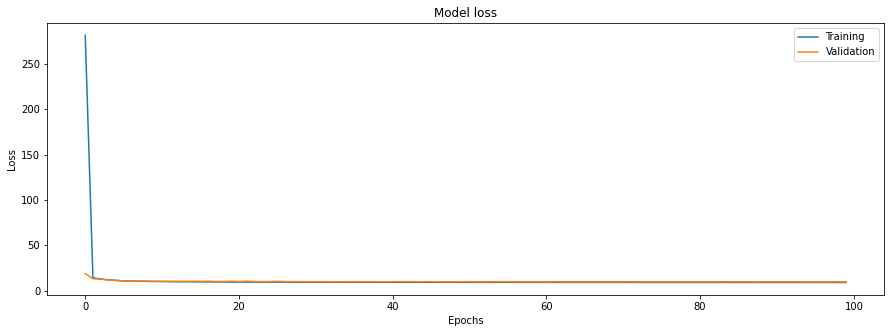

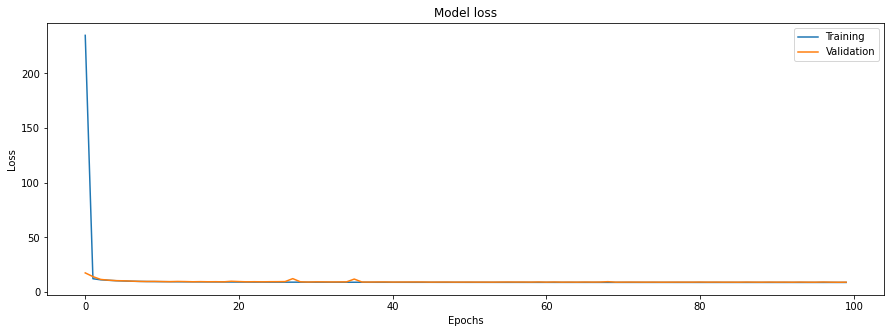

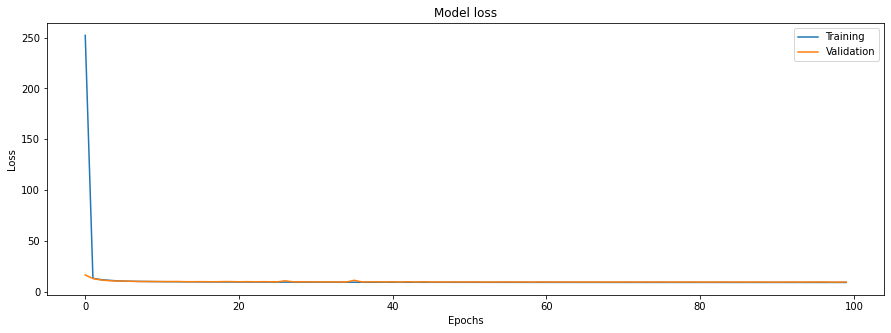

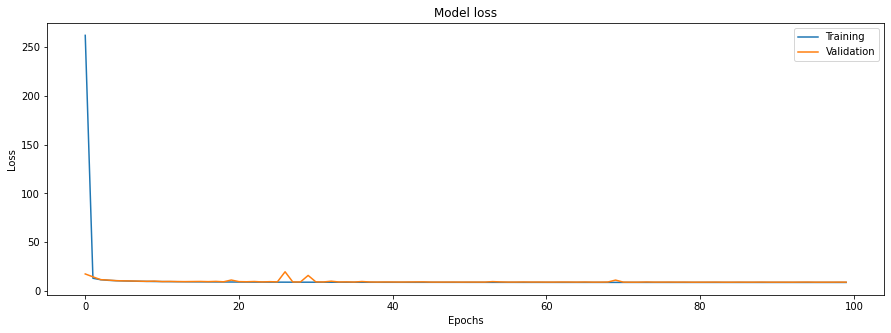

In [10]:
machine = 'fan'

csv_lines = []
csv_lines.append([machine])
csv_lines.append(["id", "AUC", "pAUC"])
as_csv = []
as_csv.append([machine])
as_csv.append(['GT', 'AS'])
performance = []

for id in machine_ids[machine]:
    data_path = '{data_dir}/train/{m}/id_{id}/*.npy'.format(data_dir=DATA_DIR, m=machine, id=id)
    paths = glob.glob(data_path)

    print('\n========== LOADING {m}: id_{id} DATA =========='.format(m=machine, id=id))
    for idx, path in tqdm(enumerate(paths)):
        spec = np.load(path)
        feature = reshape_spec(spec)
        if idx==0:
            X = feature
        else:
            X = np.concatenate((X, feature), axis=0)
    print('Training matrix shape: {}'.format(X.shape))

    model = get_model(inputDim=X.shape[1])
    model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss=LOSS)

    print('========== START {m}: id_{id} TRAINING =========='.format(m=machine, id=id))
    history = model.fit(x = X,
                        y = X,
                        epochs = EPOCHS,
                        batch_size = BATCH_SIZE,
                        shuffle=True,
                        validation_split=0.1,
                        verbose = 1)
    print('========== END TRAINING ==========')
    plot_history(history)

    #
    #   TESTING
    #

    data_path = '{data_dir}/test/{m}/id_{id}/*.npy'.format(data_dir=DATA_DIR, m=machine, id=id)
    paths = glob.glob(data_path)

    y_true = []
    y_pred = []

    print('\n========== PREDICTING {m}: id_{id} ANOMALY SCORES =========='.format(m=machine, id=id))
    
    # Cycle through test files
    for idx, path in tqdm(enumerate(paths)):

        # Load and reshape log-Mel spec 
        spec = np.load(path)
        feature = reshape_spec(spec)

        # Make predictions (row by row), calculate the reconstruction error and average it over the entire sample
        errors = np.mean(np.square(feature - model.predict(feature)), axis=1)
        y_pred.append(np.mean(errors))
        y_true.append(0 if 'normal' in path else 1)

    auc = metrics.roc_auc_score(y_true, y_pred)
    p_auc = metrics.roc_auc_score(y_true, y_pred, max_fpr=MAX_FPR)
    csv_lines.append([str(id), auc, p_auc])
    [as_csv.append([y_true[idx], score]) for idx, score in enumerate(y_pred)]
    performance.append([auc, p_auc])
    print("AUC : {}".format(auc))
    print("pAUC : {}".format(p_auc))

    del X
    del y_true
    del y_pred
    gc.collect()

averaged_performance = np.mean(np.array(performance, dtype=float), axis=0)
csv_lines.append(["Average"] + list(averaged_performance))
csv_lines.append([])

In [14]:
# output results
os.makedirs(RESULT_DIR, exist_ok=True)
result_name = '{}_results.csv'.format('fan_autoencoder')
as_name = '{}_scores.csv'.format('fan_autoencoder')
result_path = os.path.join(RESULT_DIR, result_name)
as_path = os.path.join(RESULT_DIR, as_name)
print("AUC and pAUC results -> {}".format(result_path))
print('Anomaly scores -> {}'.format(as_path))
save_csv(save_file_path=result_path, save_data=csv_lines)
save_csv(save_file_path=as_path, save_data=as_csv)

AUC and pAUC results -> ./autoencoder_result/fan_autoencoder_results.csv
Anomaly scores -> ./autoencoder_result/fan_autoencoder_scores.csv
